---

# Lib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MultiLabelBinarizer

from utils.other import parse_label

---

# Read file

In [2]:
df = pd.read_csv("../data/raw/train.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [3]:
df.head()

,brand,model,version,year,segment,comment,label
0,vinfast,vf 6,NaN,2024,suv,VF6 xe cho cá nhân dùng chứ gia đình dùng thì ...,negative
1,vinfast,vf 6,NaN,2024,suv,Xe điện mà ồn hơn xe xăng có j đó sai sai,negative
2,huyndai,accent,NaN,2024,sedan,Form này đẹp ác,positive
3,huyndai,accent,NaN,2024,sedan,Tôi thấy nó thể thao đấy chứ,positive
4,vinfast,vf 6,eco,2025,suv,Hiện tại xe VinFast chạy dịch vụ khá phổ biến....,negative


---

# EDA

In [4]:
print(f"{df.shape[0]} rows")
print(f"{df.shape[1]} columns")

3593 rows
7 columns


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3593 entries, 0 to 3592
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    3593 non-null   object
 1   model    3593 non-null   object
 2   version  2490 non-null   object
 3   year     3593 non-null   int64 
 4   segment  3593 non-null   object
 5   comment  3593 non-null   object
 6   label    3593 non-null   object
dtypes: int64(1), object(6)
memory usage: 196.6+ KB


## Missing values

Sự null này là MNAR (Missing not a random) tức version được thiếu vì:
- video, người đánh giá không đề cập rõ về version cụ thể của xe mà đánh giá chung về model xe đó hoặc các loại xe.
- Không quá khác biệt về thiết kế nột thất hoặc ngoại thất mà có thể là sự khác biệt về động cơ hoặc các tính năng, công nghệ được trang bị.
- Xe chỉ có duy nhất 1 version được bán ra thị trường với tên brand + model

In [6]:
df.isnull().sum()

brand         0
model         0
version    1103
year          0
segment       0
comment       0
label         0
dtype: int64

## Categorical columns

In [7]:
for col in df.columns[:-2]:
    num_unique_values = df[col].nunique()
    print(f"{col}: {num_unique_values} unique values")

brand: 15 unique values
model: 27 unique values
version: 27 unique values
year: 2 unique values
segment: 2 unique values


In [8]:
for col in df.columns[:-2]:
    print(f"{col}: {df[col].unique()}")
    print()

brand: ['vinfast' 'huyndai' 'skoda' 'nissan' 'toyota' 'geely' 'byd' 'mitsubishi'
 'mg' 'honda' 'omoda' 'kia' 'haval' 'hyundai' 'mazda']

model: ['vf 6' 'accent' 'slavia' 'almera' 'vios' 'coolray' 'sealion 6' 'kushaq'
 'xforce' 'zs' 'city' '5' 'c5' 'atto 3' 'corolla cross' 'seltos' 'attrage'
 'yaris cross' 'hr-v' 'jolian' 'seal 5' 'creta' 'cx-3' 'atto 2' '2'
 'kicks' 'soluto']

version: [nan 'eco' 'style' 'g' 'flagship' 'ultimate' 'ambiton' 'std' '1.5 rs' 'v'
 'cvt' 'máy xăng' 'luxury' 'plus' 'dm-i' 'n line' '1.5 at' 'facelift' 'at'
 'e-powers' '1.5 premium' '1.5 luxury' '1.5 l' '1.5 deluxe' 'e' 'active'
 'hybrid' 'l']

year: [2024 2025]

segment: ['suv' 'sedan']



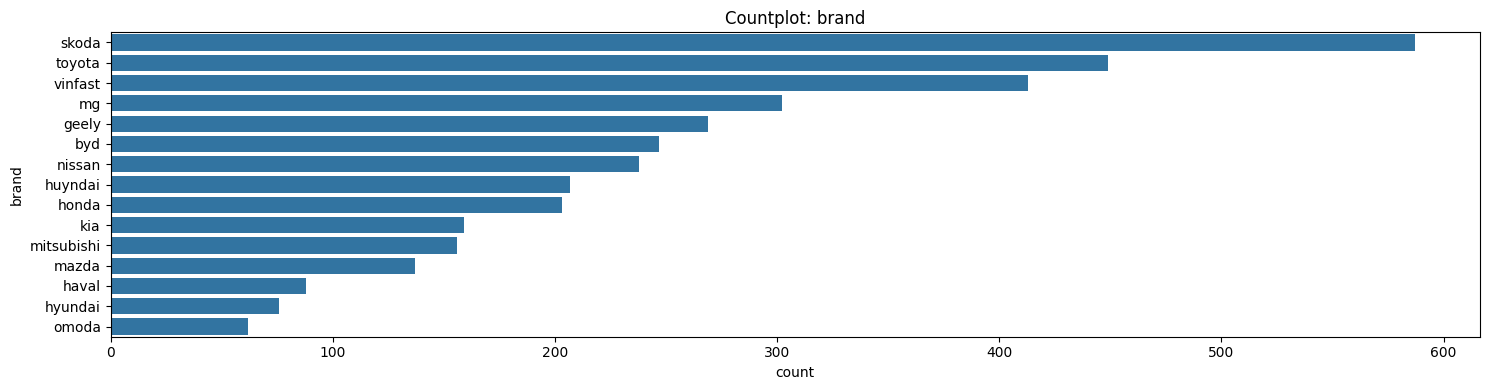

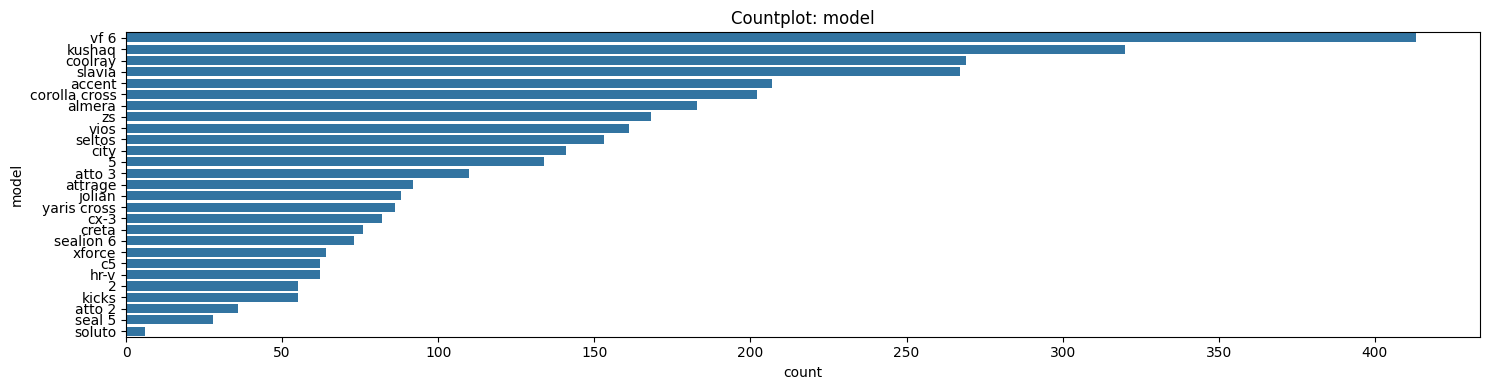

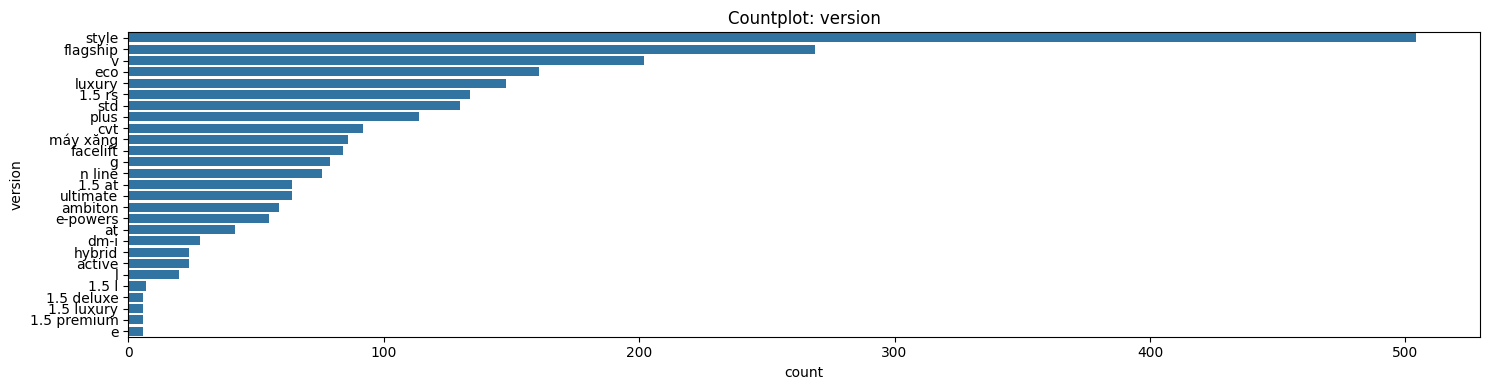

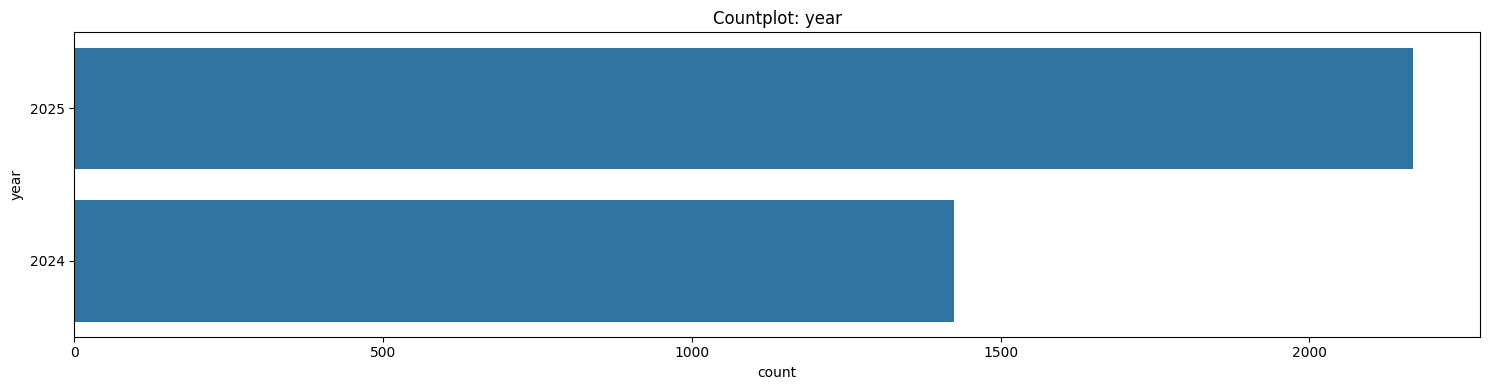

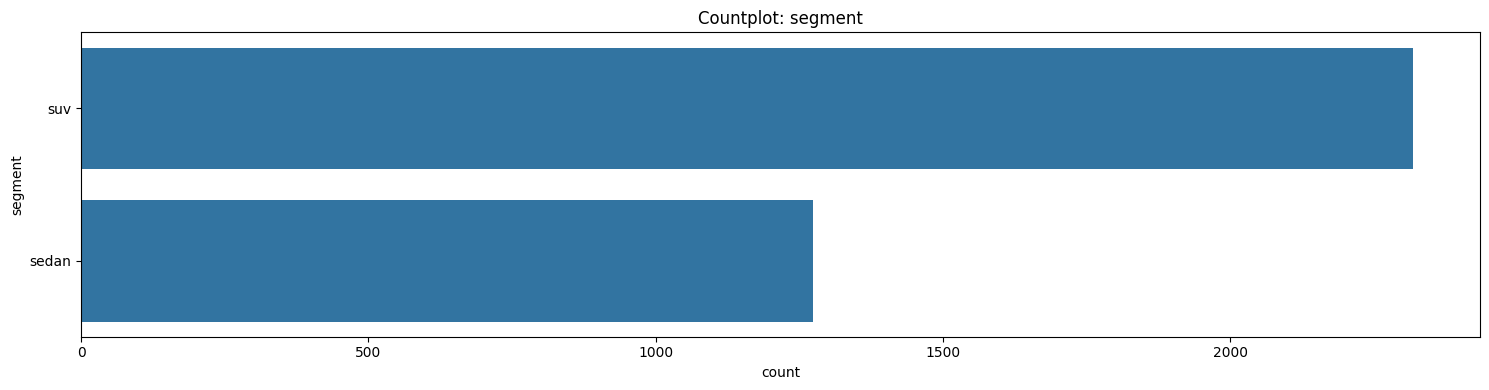

In [9]:
for col in df.columns[:-2]:
    counts = df[col].value_counts()
    plt.figure(figsize=(15, 4))
    sns.countplot(y=col, data=df, order=counts.index)
    plt.title(f"Countplot: {col}")
    plt.tight_layout()
    plt.show()

---

# Labels

In [10]:
df_label = df[["comment", "label"]].copy()

In [11]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3593 entries, 0 to 3592
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  3593 non-null   object
 1   label    3593 non-null   object
dtypes: object(2)
memory usage: 56.3+ KB


In [12]:
df_label.head()

,comment,label
0,VF6 xe cho cá nhân dùng chứ gia đình dùng thì ...,negative
1,Xe điện mà ồn hơn xe xăng có j đó sai sai,negative
2,Form này đẹp ác,positive
3,Tôi thấy nó thể thao đấy chứ,positive
4,Hiện tại xe VinFast chạy dịch vụ khá phổ biến....,negative


In [19]:
label_counts = df[["label"]].value_counts()
total_labels = df["label"].nunique()

In [20]:
print(f"Total labels: {total_labels}")

Total labels: 3


In [22]:
print(f"Unique labels: {label_counts.index.tolist()}")

Unique labels: [('positive',), ('negative',), ('neutral',)]


In [23]:
label_counts

label   
positive    1812
negative    1416
neutral      365
Name: count, dtype: int64

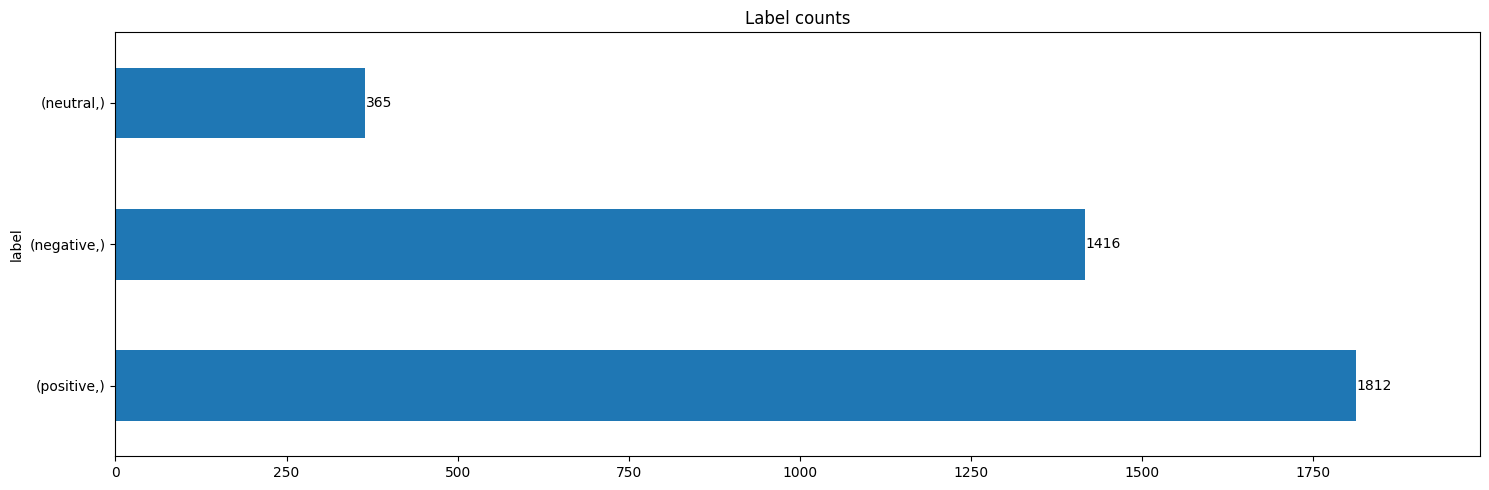

In [24]:
ax = label_counts.plot(kind='barh', figsize=(15,5), title='Label counts')
max_width = int(label_counts.max())
for p in ax.patches:
    value = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    x = p.get_x() + p.get_width() + 0.3
    ax.text(x, y, str(value), va='center', ha='left', fontsize=10)
ax.set_xlim(0, max_width * 1.10) 
plt.tight_layout()
plt.show()